In [1]:
from astropy.modeling.core import FittableModel, _CompoundModel
from astropy.modeling.models import Gaussian1D
from astropy.modeling.astro_sherpa import SherpaFitter, _astropy_to_sherpa_model
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


So were gonna make use of the mapping functionality as astropy.modeling

Firstly we define a model which take in a single input and splits into n outputs baseds on supplied indexs

I overwrite call as it's does some reshaping of the output array to match the `format_info` of the inputs but it fails. 
It's a bit of a rabbit hole I don't want to go down at the momment for a proof of concept this should be fine. I hope.

In [2]:
class Split(FittableModel):
    """
    Allows inputs to be split into multiple outputs based on indexs

    Parameters
    ----------
    split_indexes : tuple
        A tuple of integers representing indices on which the input 
        array will be split
    name : str, optional
        A human-friendly name associated with this model instance
        (particularly useful for identifying the individual components of a
        compound model).
    meta : dict-like
        Free-form metadata to associate with this model.

    """
    def __init__(self, split_indexes, name=None, meta=None):
        self._inputs = tuple('x')
        self._outputs = tuple('x' + str(idx) for idx in \
                              range(len(split_indexes)+1))
        self._split_indexes = split_indexes
        super(Split, self).__init__(name=name, meta=meta)
    
    def _format_expression(self):
        first = "x[:{0}]".format(self._split_indexes[0])
        last = "x[{0}:]".format(self._split_indexes[-1])
        if self.n_outputs > 1:
            middle = ["x[{0}:{1}]".format(*indexes) for indexes in zip(self._split_indexes[:-1], self._split_indexes[1:])]
            return ", ".join([first] + middle + [last])
        else:
            
            return ", ".join([first, last])
        
    @property
    def split_indexes(self):
        """Integers representing indices of the inputs."""
        return self._split_indexes
    
    @property
    def inputs(self):
        """
        The name(s) of the input variable(s) on which a model is evaluated.
        """
        return self._inputs

    @property
    def outputs(self):
        """The name(s) of the output(s) of the model."""
        return self._outputs

    
    def __repr__(self):
        
        if self.name is None:
            return '<SplitInput1D {0})>'.format(self._format_expression())
        else:
            return '<SplitInput1D({0}, name={1})>'.format(self._format_expression(), self.name)
    
    def evaluate(self, x):
        first = x[:self._split_indexes[0]]
        last = x[self._split_indexes[-1]:]
        if self.n_outputs>2:
            middle=[x[indexes[0]:indexes[1]] for indexes in zip(self._split_indexes[:-1], self._split_indexes[1:])]
            return [first] + middle + [last]
        else:
            return [first, last]
    
    def __call__(self, x):
        return self.evaluate(x)
    

And because we also need a single output were gonna make a join aswell which stiches the output backtogether

In [3]:
class Join(FittableModel):
    """
    Flattens output

    Parameters
    ----------
    n_inputs : int
        We need to tell it how many inputs to expect.
    name : str, optional
        A human-friendly name associated with this model instance
        (particularly useful for identifying the individual components of a
        compound model).
    meta : dict-like
        Free-form metadata to associate with this model.

    """
    
    def __init__(self, n_inputs, name=None, meta=None):
        self._inputs = tuple('x' + str(idx) for idx in range(n_inputs+1))
        self._outputs=tuple("x")
        super(Join, self).__init__(name=name, meta=meta)
 
    @property
    def inputs(self):
        """
        The name(s) of the input variable(s) on which a model is evaluated.
        """
        return self._inputs

    @property
    def outputs(self):
        """The name(s) of the output(s) of the model."""
        return self._outputs
    
    def evaluate(self, *x):
        return np.hstack(x)
    
    def __call__(self, *x):
        return self.__call__(x)


Lets make a numpy array which houses our input by stacking some arrays.

In [4]:
x1=np.arange(-0.5,0.5,0.01)
x1[50]=0 #np.arange doesnt quite put a 0 here
x2=np.arange(0.0,1,0.01)
x=np.hstack([x1]*2+[x2])
print x

[-0.5  -0.49 -0.48 -0.47 -0.46 -0.45 -0.44 -0.43 -0.42 -0.41 -0.4  -0.39
 -0.38 -0.37 -0.36 -0.35 -0.34 -0.33 -0.32 -0.31 -0.3  -0.29 -0.28 -0.27
 -0.26 -0.25 -0.24 -0.23 -0.22 -0.21 -0.2  -0.19 -0.18 -0.17 -0.16 -0.15
 -0.14 -0.13 -0.12 -0.11 -0.1  -0.09 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03
 -0.02 -0.01  0.    0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09
  0.1   0.11  0.12  0.13  0.14  0.15  0.16  0.17  0.18  0.19  0.2   0.21
  0.22  0.23  0.24  0.25  0.26  0.27  0.28  0.29  0.3   0.31  0.32  0.33
  0.34  0.35  0.36  0.37  0.38  0.39  0.4   0.41  0.42  0.43  0.44  0.45
  0.46  0.47  0.48  0.49 -0.5  -0.49 -0.48 -0.47 -0.46 -0.45 -0.44 -0.43
 -0.42 -0.41 -0.4  -0.39 -0.38 -0.37 -0.36 -0.35 -0.34 -0.33 -0.32 -0.31
 -0.3  -0.29 -0.28 -0.27 -0.26 -0.25 -0.24 -0.23 -0.22 -0.21 -0.2  -0.19
 -0.18 -0.17 -0.16 -0.15 -0.14 -0.13 -0.12 -0.11 -0.1  -0.09 -0.08 -0.07
 -0.06 -0.05 -0.04 -0.03 -0.02 -0.01  0.    0.01  0.02  0.03  0.04  0.05
  0.06  0.07  0.08  0.09  0.1   0.11  0.12  0.13  0

We want to split the data every 100 values so lets define the split and the corisponting join.

astropy requires Join to know how many inputs its taking so thats why we supply it with the lenght of `split_indexs`

In [5]:
split_indexs=[100,200]
splitin=Split(split_indexs)
joinout=Join(len(split_indexs))

Lets check it looks right (I set the 0s so it prints nicely)

In [6]:
for sx in splitin(x):
    print sx

[-0.5  -0.49 -0.48 -0.47 -0.46 -0.45 -0.44 -0.43 -0.42 -0.41 -0.4  -0.39
 -0.38 -0.37 -0.36 -0.35 -0.34 -0.33 -0.32 -0.31 -0.3  -0.29 -0.28 -0.27
 -0.26 -0.25 -0.24 -0.23 -0.22 -0.21 -0.2  -0.19 -0.18 -0.17 -0.16 -0.15
 -0.14 -0.13 -0.12 -0.11 -0.1  -0.09 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03
 -0.02 -0.01  0.    0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09
  0.1   0.11  0.12  0.13  0.14  0.15  0.16  0.17  0.18  0.19  0.2   0.21
  0.22  0.23  0.24  0.25  0.26  0.27  0.28  0.29  0.3   0.31  0.32  0.33
  0.34  0.35  0.36  0.37  0.38  0.39  0.4   0.41  0.42  0.43  0.44  0.45
  0.46  0.47  0.48  0.49]
[-0.5  -0.49 -0.48 -0.47 -0.46 -0.45 -0.44 -0.43 -0.42 -0.41 -0.4  -0.39
 -0.38 -0.37 -0.36 -0.35 -0.34 -0.33 -0.32 -0.31 -0.3  -0.29 -0.28 -0.27
 -0.26 -0.25 -0.24 -0.23 -0.22 -0.21 -0.2  -0.19 -0.18 -0.17 -0.16 -0.15
 -0.14 -0.13 -0.12 -0.11 -0.1  -0.09 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03
 -0.02 -0.01  0.    0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09
  0.1   0.11  0.12  0.13 

We can define the model like this which is really cool :)

In [7]:
m=splitin| Gaussian1D(0.2,0.05,0.1) & Gaussian1D(0.2,0.01,0.2) & Gaussian1D(0.3,0.6,0.05) | joinout

lets evaluate the model an plot the outputs

(0.0, 0.32)

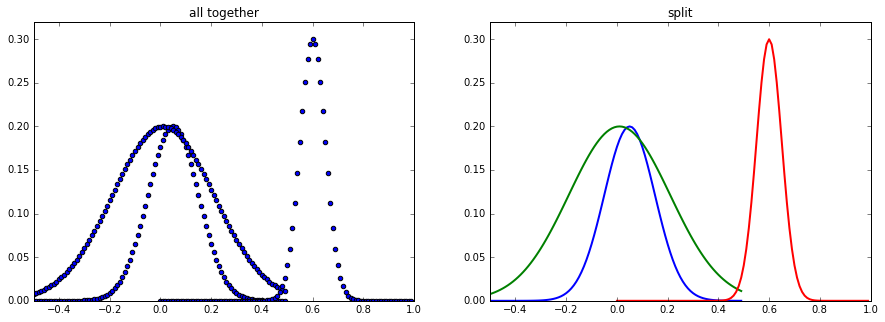

In [8]:
plt.rcParams['figure.figsize']=(15,5)
y=m(x)
plt.subplot(1,2,1)
plt.scatter(x,y)
plt.title("all together")
plt.xlim((-0.5,1))
plt.ylim((0.0,0.32))

plt.subplot(1,2,2)
for sx,sy in zip(splitin(x),splitin(y)):
    plt.plot(sx,sy,lw=2)
plt.title("split")
plt.xlim((-0.5,1))
plt.ylim((0.0,0.32))


In [9]:
from sherpa.stats import Chi2
from collections import defaultdict
from itertools import cycle

sfit = SherpaFitter(statistic=Chi2())

model = (Gaussian1D(amplitude=1.2, mean=0.9, stddev=0.5) +
         Gaussian1D(amplitude=2.0, mean=-0.9, stddev=0.75))

err = 0.05
x = np.arange(-3, 3, .001)
y = []
yerrs = []

y.append(model(x))
yerrs.append(err * np.random.uniform(size=len(x)))

model.amplitude_0 = 1.0
model.mean_1 = -1
y.append(model(x))
yerrs.append(err * np.random.uniform(size=len(x)))


model.amplitude_0 = 0.6
model.mean_1 = -0.4
y.append(model(x))
yerrs.append(err * np.random.uniform(size=len(x)))


model.amplitude_1 = 0.2
model.mean_1 = -2
y.append(model(x))
yerrs.append(err * np.random.uniform(size=len(x)))


model.amplitude_0 = 2
model.mean_0 = 1
model.stddev_0 = 0.2
model.amplitude_1 = 1.5
model.mean_1 = -0.4
model.stddev_1 = 0.35
 
plt.rcParams['figure.figsize'] = (15, 10)
plt.ion()

In [10]:
split_indexes=[i*len(x) for i in xrange(1,len(y))]
print split_indexes
splitin=Split(split_indexes)
joinout=Join(len(split_indexes))
xstack=np.hstack([x for _ in xrange(len(y))])
ystack=np.hstack(y)
yerrstack=np.hstack(yerrs)
print xstack.shape,ystack.shape,yerrstack.shape

[6000, 12000, 18000]
(24000,) (24000,) (24000,)


In [19]:
sim_model = model.copy()
for i in xrange(1,len(y)):
    sim_model &=model.copy()
sim_model = splitin | sim_model | joinout

def tiefunc(self):
    return 0.9*self.amplitude_3

sim_model.amplitude_1.tied =  tiefunc # example tie

In [20]:
fitmodel = sfit(sim_model, xstack, ystack, yerr=yerrstack)
err_res2 = sfit.est_errors(sigma=1)

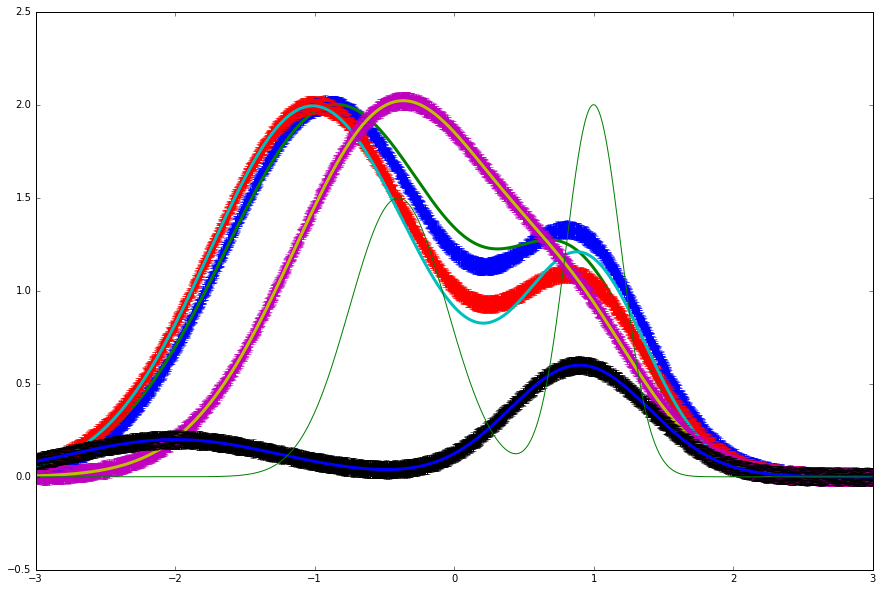

In [14]:
fity=fitmodel(xstack)
for xspl,yspl,yerrspl,fityspl in zip(splitin(xstack),splitin(ystack),splitin(yerrstack),splitin(fity)):
    plt.errorbar(xspl,yspl,yerr=yerrspl)
    plt.plot(xspl,fityspl,lw=3)
plt.plot(x,model(x))